In [258]:
import pandas as pd

# Path: data_analysis.py
model_name = 'tgredial'
dataset_name = 'redial'
data_path = 'bias_analysis_data_set/Equal_showup/bias_analysis_data/{}/{}/bias_analytic_data_01.csv'.format(model_name,dataset_name)
basic_data_path = 'bias_analysis_data_set/Basic/bias_analysis_data_01/{}/{}/bias_analytic_data.csv'.format(model_name,dataset_name)
once_aug_data_path = 'bias_analysis_data_set/bias_eval_once_aug/{}/{}/bias_analytic_data.csv'.format(model_name,dataset_name)
popnudge_data_path = 'bias_analysis_data_set/PopNudge/{}/{}/bias_analytic_data_k50.csv'.format(model_name,dataset_name)

data = pd.read_csv(popnudge_data_path)
# basic_data = pd.read_csv(basic_data_path)
# data['target_item'] = basic_data['target_item']

### Calculate Recommendation Performance

In [213]:
import functools
from abc import ABC, abstractmethod
import torch
import math
from typing import Any, Union, List, Optional, Dict
import json
TScalar = Union[int, float, torch.Tensor]
TVector = Union[List[TScalar], torch.Tensor]

@functools.total_ordering
class Metric(ABC):
    """
    Base class for storing metrics.

    Subclasses should define .value(). Examples are provided for each subclass.
    """

    @abstractmethod
    def value(self) -> float:
        """
        Return the value of the metric as a float.
        """
        pass

    @abstractmethod
    def __add__(self, other: Any) -> 'Metric':
        raise NotImplementedError

    def __iadd__(self, other):
        return self.__radd__(other)

    def __radd__(self, other: Any):
        if other is None:
            return self
        return self.__add__(other)

    def __str__(self) -> str:
        return f'{self.value():.4g}'

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}({self.value():.4g})'

    def __float__(self) -> float:
        return float(self.value())

    def __int__(self) -> int:
        return int(self.value())

    def __eq__(self, other: Any) -> bool:
        if isinstance(other, Metric):
            return self.value() == other.value()
        else:
            return self.value() == other

    def __lt__(self, other: Any) -> bool:
        if isinstance(other, Metric):
            return self.value() < other.value()
        else:
            return self.value() < other

    def __sub__(self, other: Any) -> float:
        """
        Used heavily for assertAlmostEqual.
        """
        if not isinstance(other, float):
            raise TypeError('Metrics.__sub__ is intentionally limited to floats.')
        return self.value() - other

    def __rsub__(self, other: Any) -> float:
        """
        Used heavily for assertAlmostEqual.

        NOTE: This is not necessary in python 3.7+.
        """
        if not isinstance(other, float):
            raise TypeError('Metrics.__rsub__ is intentionally limited to floats.')
        return other - self.value()

    @classmethod
    def as_number(cls, obj: TScalar) -> Union[int, float]:
        if isinstance(obj, torch.Tensor):
            obj_as_number: Union[int, float] = obj.item()
        else:
            obj_as_number = obj  # type: ignore
        assert isinstance(obj_as_number, int) or isinstance(obj_as_number, float)
        return obj_as_number

    @classmethod
    def as_float(cls, obj: TScalar) -> float:
        return float(cls.as_number(obj))

    @classmethod
    def as_int(cls, obj: TScalar) -> int:
        return int(cls.as_number(obj))

    @classmethod
    def many(cls, *objs: List[TVector]) -> List['Metric']:
        """
        Construct many of a Metric from the base parts.

        Useful if you separately compute numerators and denomenators, etc.
        """
        lengths = [len(o) for o in objs]
        if len(set(lengths)) != 1:
            raise IndexError(f'Uneven {cls.__name__} constructions: {lengths}')
        return [cls(*items) for items in zip(*objs)]


class AverageMetric(Metric):
    """
    Class that keeps a running average of some metric.

    Examples of AverageMetrics include hits@1, F1, accuracy, etc. These metrics all have
    per-example values that can be directly mapped back to a teacher.
    """

    __slots__ = ('_numer', '_denom')

    def __init__(self, numer: TScalar, denom: TScalar = 1.0):
        self._numer = self.as_number(numer)
        self._denom = self.as_number(denom)

    def __add__(self, other: Optional['AverageMetric']) -> 'AverageMetric':
        # NOTE: hinting can be cleaned up with "from __future__ import annotations" when
        # we drop Python 3.6
        if other is None:
            return self
        full_numer: TScalar = self._numer + other._numer
        full_denom: TScalar = self._denom + other._denom
        # always keep the same return type
        return type(self)(numer=full_numer, denom=full_denom)

    def value(self) -> float:
        if self._numer == 0 and self._denom == 0:
            # don't nan out if we haven't counted anything
            return 0.0
        if self._denom == 0:
            return float('nan')
        return self._numer / (1.0 * self._denom)


class Metrics(object):
    """
    Metrics aggregator.
    """

    def __init__(self):
        self._data = {}

    def __str__(self):
        return str(self._data)

    def __repr__(self):
        return f'Metrics({repr(self._data)})'

    def get(self, key: str):
        if key in self._data.keys():
            return self._data[key].value()
        else:
            raise

    def __getitem__(self, item):
        return self.get(item)

    def add(self, key: str, value: Optional[Metric]) -> None:
        """
        Record an accumulation to a metric.
        """
        self._data[key] = self._data.get(key) + value

    def report(self):
        """
        Report the metrics over all data seen so far.
        """
        return {k: v for k, v in self._data.items()}

    def clear(self):
        """
        Clear all the metrics.
        """
        self._data.clear()


class HitMetric(AverageMetric):
    @staticmethod
    def compute(ranks, label, k) -> 'HitMetric':
        return HitMetric(int(label in ranks[:k]))


class NDCGMetric(AverageMetric):
    @staticmethod
    def compute(ranks, label, k) -> 'NDCGMetric':
        if label in ranks[:k]:
            label_rank = ranks.index(label)
            return NDCGMetric(1.0 / math.log2(label_rank + 2))
        return NDCGMetric(0)


class MRRMetric(AverageMetric):
    @staticmethod
    def compute(ranks, label, k) -> 'MRRMetric':
        if label in ranks[:k]:
            label_rank = ranks.index(label)
            return MRRMetric(1.0 / (label_rank + 1))
        return MRRMetric(0)
    
rec_metrics = Metrics()

def rec_evaluate(ranks, label):
    for k in [1, 10, 50]:
        if len(ranks) >= k:
            rec_metrics.add(f"hit@{k}", HitMetric.compute(ranks, label, k))
            rec_metrics.add(f"ndcg@{k}", NDCGMetric.compute(ranks, label, k))
            rec_metrics.add(f"mrr@{k}", MRRMetric.compute(ranks, label, k))

movie_ids = json.load(open('Movie_IDS/ReDial/BERT/movie_ids.json', 'r'))

for idx, row in data.iterrows():
    rec_rank = row['Prediction']
    item_index = row['target_item_index']
    item_id = str(movie_ids.index(item_index))
    rec_evaluate(rec_rank, item_id)

In [214]:
rec_metrics.report()

{'hit@1': HitMetric(0),
 'ndcg@1': NDCGMetric(0),
 'mrr@1': MRRMetric(0),
 'hit@10': HitMetric(0.04572),
 'ndcg@10': NDCGMetric(0.0254),
 'mrr@10': MRRMetric(0.01874),
 'hit@50': HitMetric(0.1621),
 'ndcg@50': NDCGMetric(0.05185),
 'mrr@50': MRRMetric(0.0249)}

In [33]:
import json
tok_type = 'BERT'
movie_id_dir = f'Movie_IDs/redial/{tok_type}/movie_ids.json'
movie_entity_ids = json.load(open(movie_id_dir, 'r', encoding='utf-8'))

def convert_ids(x):    
    return movie_entity_ids.index(x)

# data['item'] = list(map(convert_ids, data['target_item']))

In [4]:
entity2id_file = 'training_data/redial/entity2id.json'
movie_ids = json.load(open('Movie_IDs/ReDial/BERT/movie_ids.json', 'r'))
entity2id = json.load(open(entity2id_file, 'r', encoding='utf-8'))
training_data = json.load(open('training_data/redial/train_data_normal_aug.json', 'r', encoding='utf-8'))

# item_frequency = {}
# for key in entity2id.keys():
#     if key[:2] == '<h':
#     # if key in [36,56,96,1087,1776,1874,1922,1985,2046,9413,201413]:
#         item_frequency[int(entity2id[key])] = 0

# Initialise included movies
item_frequency = {}
for key in entity2id.keys():
    if key[:5] == '<http' and entity2id[key] in movie_ids:
        item_frequency[int(entity2id[key])] = 1

for utt in training_data:
    dialogs = utt['dialog']
    for dialog in dialogs:
        if len(dialog['movies']) == 0:
            continue
        mentioned_movies = [int(entity2id[movie]) for movie in dialog['movies'] if movie in entity2id]
        for movie in mentioned_movies:
            if movie in item_frequency:
                item_frequency[movie] += 1

# for utt in training_data:
#     dialogs = utt['messages']
#     for dialog in dialogs:
#         if len(dialog['movie']) == 0:
#             continue
#         mentioned_movies = [int(entity2id[movie]) for movie in dialog['movie'] if movie in entity2id]
#         for movie in mentioned_movies:
#             if movie in item_frequency:
#                 item_frequency[movie] += 1

In [61]:
item_frequency = json.load(open('Movie_IDs/ReDial/BERT/movie_frequency.json', 'r', encoding='utf-8'))

In [5]:
item_frequency = {k: v for k, v in sorted(item_frequency.items(), key=lambda item: item[1], reverse=True)}
print(list(item_frequency.keys())[-10:])
print(list(item_frequency.values())[-10:])
len(item_frequency)

[62678, 62822, 63320, 63489, 63919, 63963, 64081, 64106, 64164, 64316]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


6112

In [6]:
interacted_items = 0
for item in item_frequency:
    if item_frequency[item] != 0:
        interacted_items += 1
print(interacted_items / len(item_frequency) * 1.0)    

1.0


In [7]:
interacted_items = 0
for item in item_frequency:
    if item_frequency[item] >= 5:
        interacted_items += 1
print(interacted_items / len(item_frequency) * 1.0) 

0.4651505235602094


In [8]:
len(item_frequency)

6112

In [11]:
len(movie_ids)

6924

Text(0, 0.5, 'Frequency')

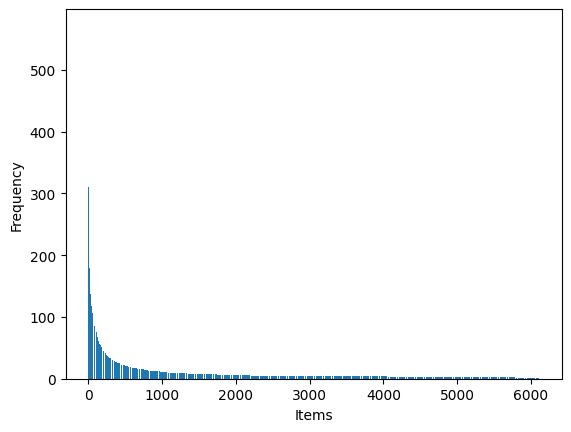

In [38]:
# ReDial Dataset
import matplotlib.pyplot as plt
item_frequency = {k: v for k, v in sorted(item_frequency.items(), key=lambda item: item[1], reverse=True)}
plt.bar(range(len(item_frequency)), list(item_frequency.values()), align='center')
plt.xlabel('Items')
plt.ylabel('Frequency')

In [24]:
# pop_items = list(item_frequency.keys())[:int(len(item_frequency) * 0.2)]
pop_items = list(item_frequency.keys())
len(pop_items)

6112

In [19]:
pop_score_dict = {}
for index,value in enumerate(list(item_frequency.keys())):
  pop_score_dict[value] = 1 - index / len(item_frequency)

## Calculate popularity score of recommendations

In [259]:
import numpy as np
def rank_utility(items):
    utility_score = 0
    for idx in range(1, len(items) + 1):
        if items[idx - 1] in pop_items:
            utility_score += 1 / (np.log(idx) + 1) 
    return utility_score

def pop_coverage(items):
    return len(set(items).intersection(set(pop_items))) / (1.0 * len(items))

def list_to_int(item_str):
    item_ids = item_str.strip('][').split(', ')
    while("" in item_ids):
        item_ids.remove("")
    return list(map(int, item_ids))

data['Prediction_items'] = list(map(list_to_int, data['Prediction']))
data['pop_coverage'] = list(map(pop_coverage, data['Prediction_items']))
data['rank_utility'] = list(map(rank_utility, data['Prediction_items']))
data['pop_bias'] = data['pop_coverage'] * data['rank_utility']
print("mean: ", data['pop_bias'].mean())
print("std: ", data['pop_bias'].std())
# print("variance: ", data['pop_bias'].var())

mean:  0.13886092413404386
std:  0.11783659989523754


In [260]:
# Calculate CEP score
from scipy.stats.stats import pearsonr

def compute_pop_scores(pop_score_dict, items):
    return [pop_score_dict[item] if item in pop_score_dict else 0.0 for item in items]

pop_scores = [compute_pop_scores(pop_score_dict, row['Prediction_items']) for _, row in data.iterrows()]
data['pop_scores'] = pop_scores

new_conv = True
cep_scores = []
for idx, row in data.iterrows():
    if new_conv:
        new_conv = False
        cep_scores.append(0.5)
    else:
        if idx+1 < len(data) and row['conv_id'] != data.at[idx+1, 'conv_id']:
            new_conv=True
        pearsonr_score = np.abs(pearsonr(row['pop_scores'], data.at[idx-1, 'pop_scores'])[0])
        cep_scores.append(pearsonr_score)

data['cep_score'] = cep_scores
data['cep_pop_score'] = data['cep_score'] * data['pop_bias']
print("mean: ", data['cep_pop_score'].mean())
print("std: ", data['cep_pop_score'].std())

/var/folders/00/7dpx5xyd31x3l547cfrv98rc0000gn/T/ipykernel_13187/430041714.py:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr
/Users/ucl/miniconda3/envs/AMT/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


mean:  0.05647628442380027
std:  0.08132266281145553


In [261]:
# calculate UIOP score
data['target_pop_score'] = data['target_item_index'].map(pop_score_dict)
data['UIOP'] = np.abs(data['pop_bias'] - data['target_pop_score'])
print("mean: ", data['UIOP'].mean())
print("std: ", data['UIOP'].std())

mean:  0.6972357937045078
std:  0.2577170636190518


### Redial Dataset

In [196]:
redial_redial = list(data['pop_bias'])

In [69]:
tgredial_redial = list(data['pop_bias'])

In [206]:
kbrd_redial = list(data['pop_bias'])

In [211]:
kgsf_redial = list(data['pop_bias'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdc483bd240>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdc483bd780>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdc483bcfa0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdc483bdcc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdc483bdf60>],
 'means': []}

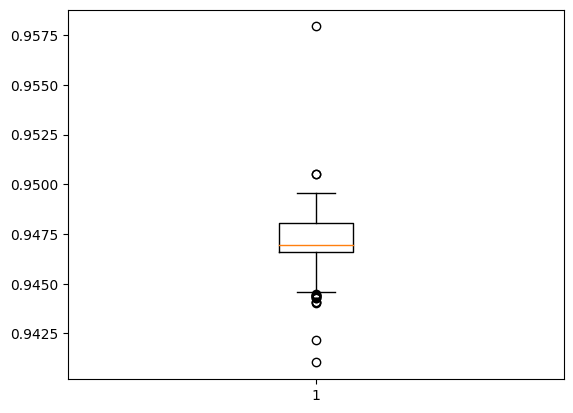

In [197]:
# redial_redial
# Average scores: 0.9471294843840329
plt.boxplot(redial_redial)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f880c438f70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f880c4394b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f880c438cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f880c4399f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f880c439c90>],
 'means': []}

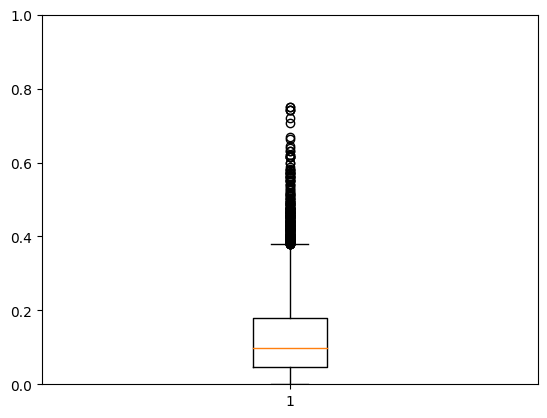

In [70]:
# tgredial_redial
# Average scores: 1.2895797709975179
# After
plt.ylim(0, 1)
plt.boxplot(tgredial_redial)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f880c49d240>,
 'caps': [<matplotlib.lines.Line2D at 0x7f880c49d780>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f880c49cfa0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f880c49dc30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f880c49ded0>],
 'means': []}

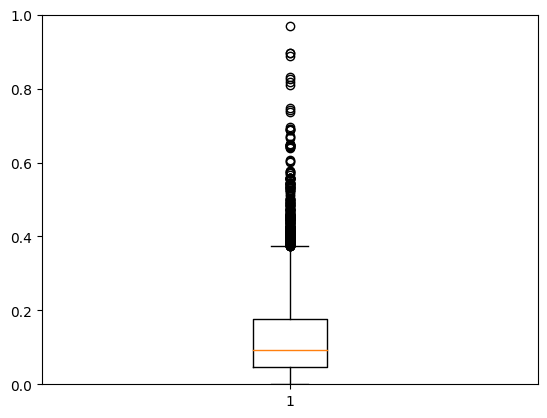

In [64]:
# tgredial_redial
# Average scores: 1.2895797709975179
# before
plt.ylim(0, 1)
plt.boxplot(tgredial_redial)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdc49b2c6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdc49b2cc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdc49b2c430>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdc49b2d150>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdc49b2d3f0>],
 'means': []}

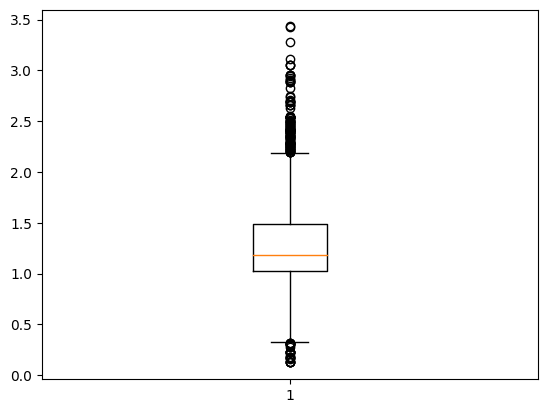

In [207]:
# kbrd_redial
# Average scores: 1.2635615913894107
plt.boxplot(kbrd_redial)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdc479b8100>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdc479b8640>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdc482d7c70>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdc479b8b80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdc479b8e20>],
 'means': []}

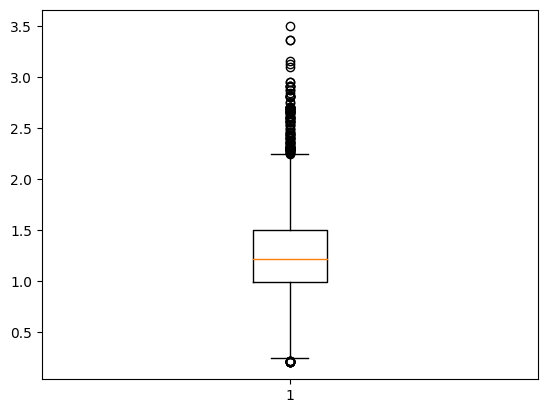

In [212]:
# kgsf_redial
# Average scores: 1.2729196510587255
plt.boxplot(kgsf_redial)

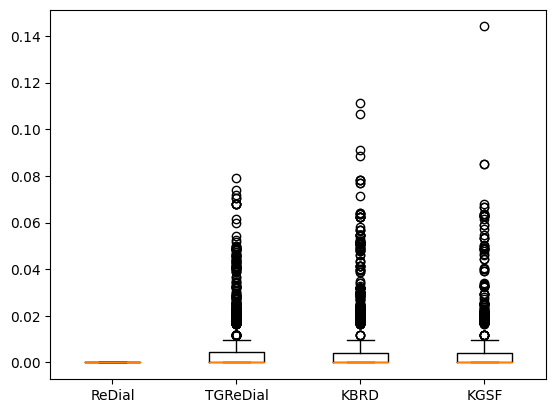

In [150]:
%matplotlib inline
plt.boxplot([redial_redial, tgredial_redial, kbrd_redial, kgsf_redial], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF'])
plt.savefig('pop_bias.pdf')

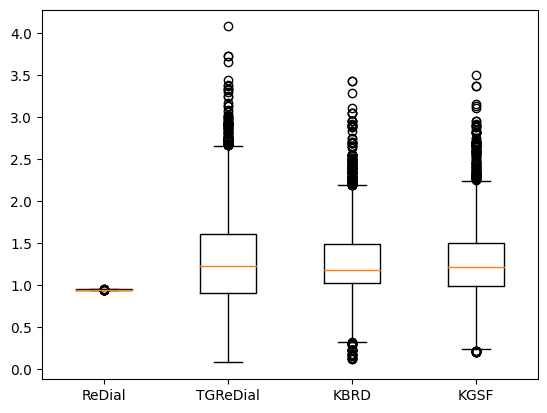

In [213]:
%matplotlib inline
plt.boxplot([redial_redial, tgredial_redial, kbrd_redial, kgsf_redial], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF'])
plt.savefig('pop_bias_0.1.pdf')

0.6460560371728898


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe0459120>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe045ac80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe04585b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe045b1c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe045b460>],
 'means': []}

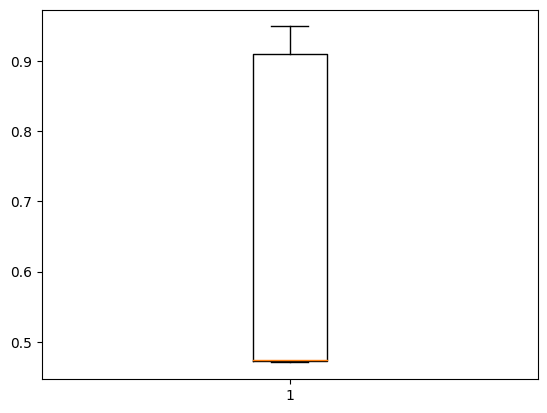

In [248]:
# redial_redial
redial_redial = list(data['cep_pop_score'])
print(np.average(redial_redial))
plt.boxplot(redial_redial)

0.5515322307774588


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdc71a95300>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdc71a95840>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdc71a95060>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdc71a95d80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdc71a96020>],
 'means': []}

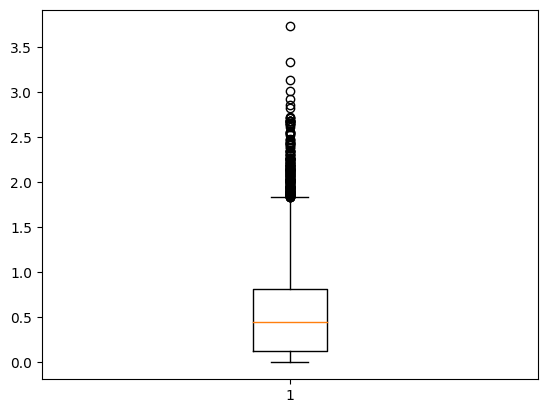

In [243]:
# tgredial_redial
tgredial_redial = list(data['cep_pop_score'])
print(np.average(tgredial_redial))
plt.boxplot(tgredial_redial)

0.6270706900397248


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdc49609240>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdc49609780>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdc49608fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdc49609cc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdc49609f60>],
 'means': []}

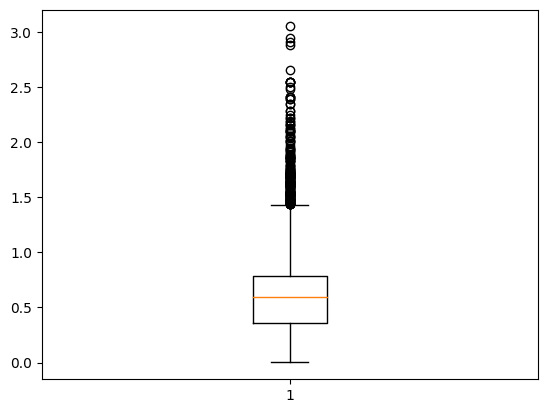

In [253]:
# kbrd_redial
kbrd_redial = list(data['cep_pop_score'])
print(np.average(kbrd_redial))
plt.boxplot(kbrd_redial)

0.4794336844061796


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdc71ae6bf0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdc71ae7130>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdc71ae6950>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdc71ae7670>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdc71ae7910>],
 'means': []}

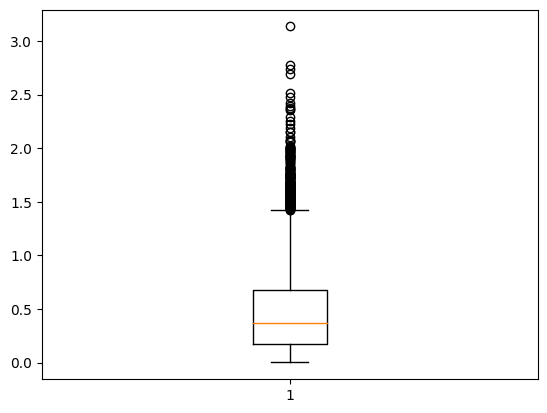

In [272]:
# tgredial_redial
tgredial_redial = list(data['UIOP'])
print(np.average(tgredial_redial))
plt.boxplot(tgredial_redial)

0.6230979878891306


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdc45544130>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdc45544670>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe00c6680>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdc45544bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdc45544e50>],
 'means': []}

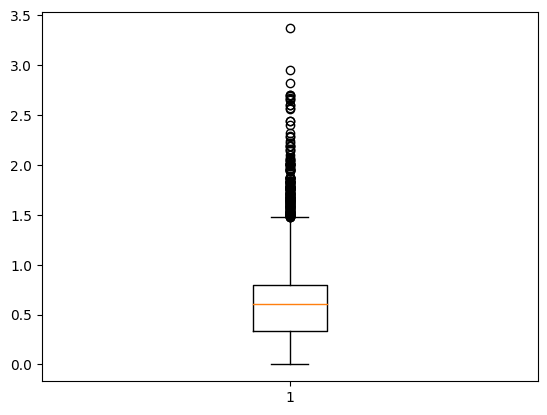

In [258]:
# kgsf_redial
kgsf_redial = list(data['cep_pop_score'])
print(np.average(kgsf_redial))
plt.boxplot(kgsf_redial)

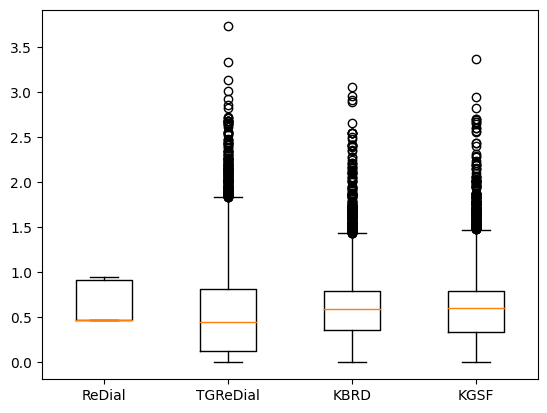

In [259]:
%matplotlib inline
plt.boxplot([redial_redial, tgredial_redial, kbrd_redial, kgsf_redial], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF'])
plt.savefig('cep_pop_bias.pdf')

0.02754642897005535


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe3741390>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe3741600>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe3741150>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe3741b40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe3741de0>],
 'means': []}

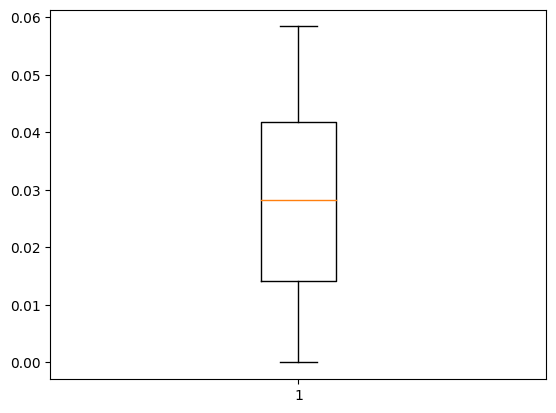

In [278]:
# redial_redial
redial_redial = list(data['UIOP'])
print(np.average(redial_redial))
plt.boxplot(redial_redial)

0.4794336844061796


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbdf7521a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbdf7525c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbdf751f00>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbdf752b00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbdf752da0>],
 'means': []}

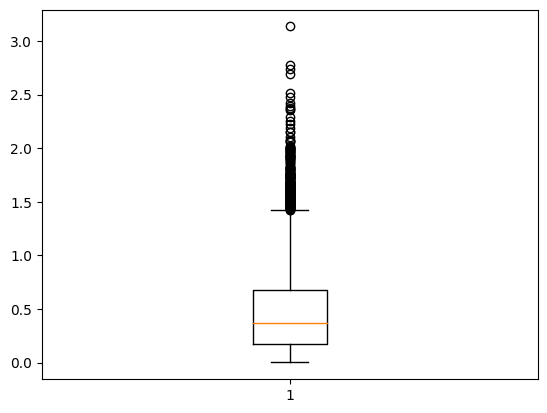

In [273]:
# tgredial_redial
tgredial_redial = list(data['UIOP'])
print(np.average(tgredial_redial))
plt.boxplot(tgredial_redial)

0.40738889875048456


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbdf4044c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbdf404a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbdf404220>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbdf404f40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbdf4051e0>],
 'means': []}

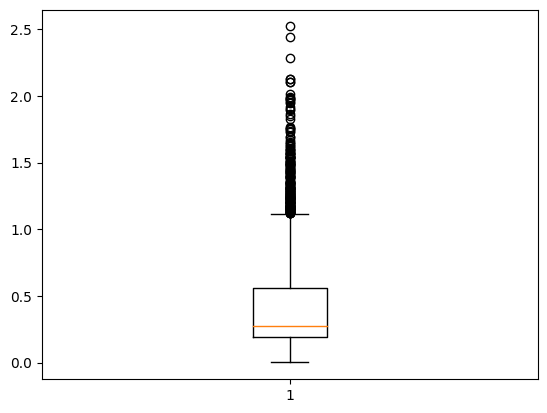

In [267]:
# kbrd_redial
kbrd_redial = list(data['UIOP'])
print(np.average(kbrd_redial))
plt.boxplot(kbrd_redial)

0.4233161286083629


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbde6fd810>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbde6fdd50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbde6fd570>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbde6fe290>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbde6fe530>],
 'means': []}

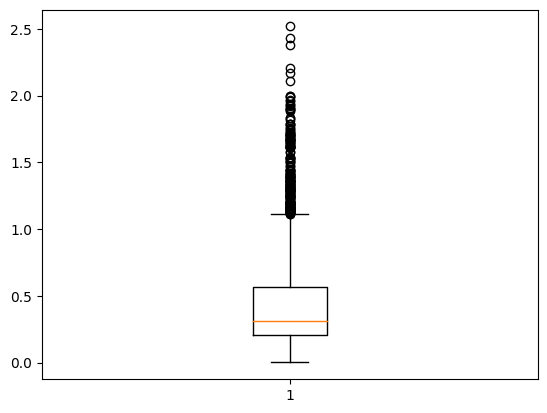

In [262]:
# kgsf_redial
kgsf_redial = list(data['UIOP'])
print(np.average(kgsf_redial))
plt.boxplot(kgsf_redial)

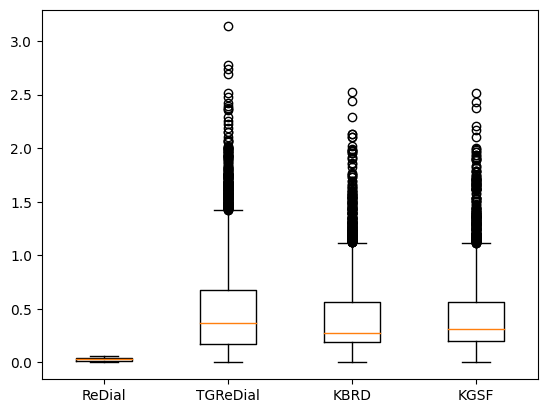

In [279]:
%matplotlib inline
plt.boxplot([redial_redial, tgredial_redial, kbrd_redial, kgsf_redial], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF'])
plt.savefig('uiop_pop_bias.pdf')

0.6820949467860936


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe0d3a2f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe0d3a830>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe0d3a050>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe0d3ad70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe0d3b010>],
 'means': []}

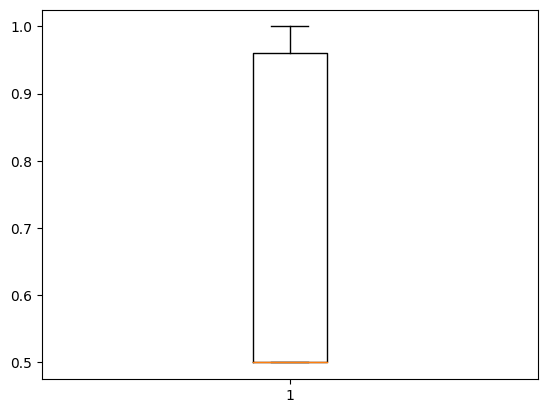

In [287]:
# redial_redial
redial_redial_cep = list(data['cep_score'])
print(np.average(redial_redial_cep))
plt.boxplot(redial_redial_cep)

0.02754642897005535


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe1d95150>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe1d95690>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe1d94eb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe1d95ab0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe1d95d50>],
 'means': []}

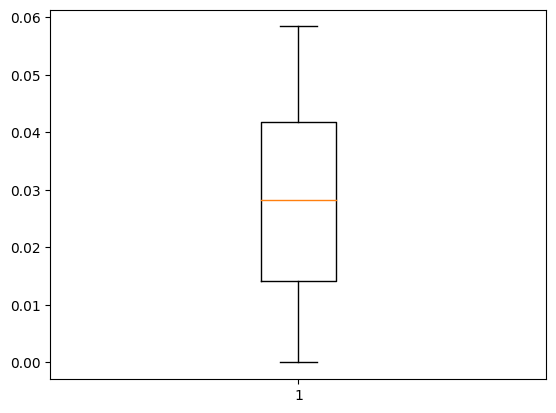

In [288]:
# redial_redial
redial_redial_uiop = list(data['UIOP'])
print(np.average(redial_redial_uiop))
plt.boxplot(redial_redial_uiop)

0.42572958617624146


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe123c5b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe123d210>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe123f280>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe123fd00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe123ffa0>],
 'means': []}

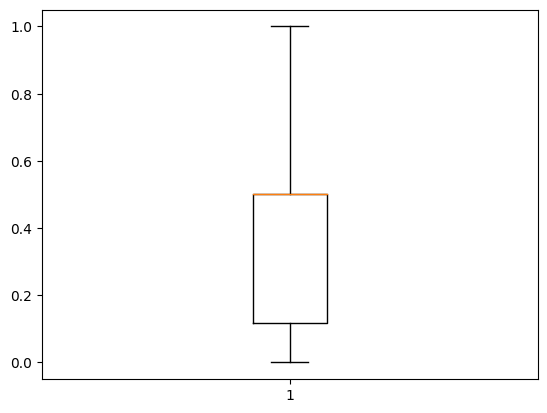

In [295]:
# tgredial_redial_cep
tgredial_redial_cep = list(data['cep_score'])
print(np.average(tgredial_redial_cep))
plt.boxplot(tgredial_redial_cep)

0.4794336844061796


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe0f05e10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe0f06350>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe0f05b70>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe0f06890>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe0f06b30>],
 'means': []}

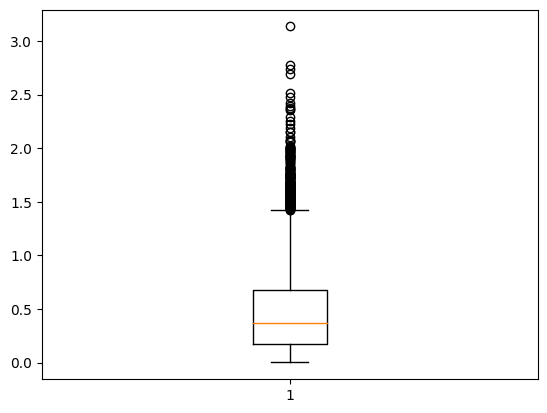

In [296]:
# tgredial_redial_uiop
tgredial_redial_uiop = list(data['UIOP'])
print(np.average(tgredial_redial_uiop))
plt.boxplot(tgredial_redial_uiop)

0.49820295559173344


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe1e0a080>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe1e0a5c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe1e09660>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe1e0ab00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe1e0ada0>],
 'means': []}

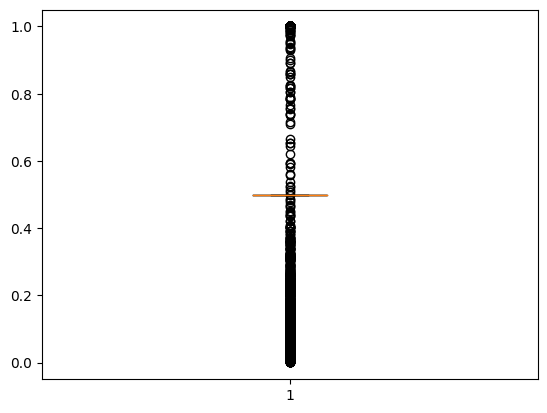

In [302]:
# kbrd_redial_cep
kbrd_redial_cep = list(data['cep_score'])
print(np.average(kbrd_redial_cep))
plt.boxplot(kbrd_redial_cep)

0.40738889875048456


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe615c100>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe615c640>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe617fe20>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe615ca60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe615cd00>],
 'means': []}

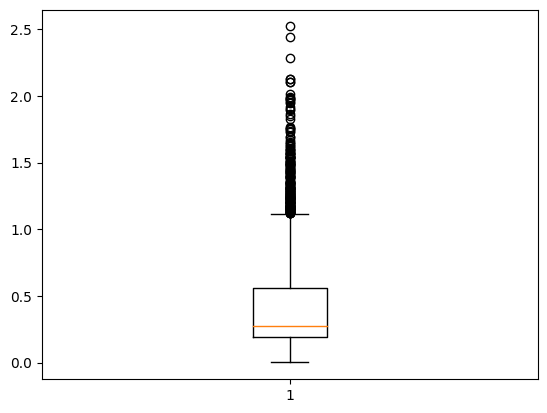

In [303]:
# kbrd_redial_uiop
kbrd_redial_uiop = list(data['UIOP'])
print(np.average(kbrd_redial_uiop))
plt.boxplot(kbrd_redial_uiop)

0.4922109862005713


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe44de1d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe44dfb20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe44ddc30>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe61d80a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe61d8340>],
 'means': []}

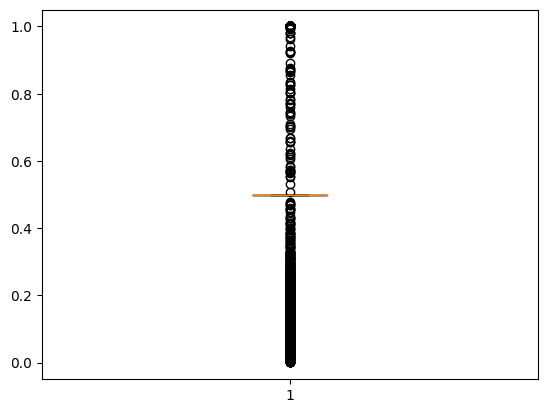

In [309]:
# kgsf_redial_cep
kgsf_redial_cep = list(data['cep_score'])
print(np.average(kgsf_redial_cep))
plt.boxplot(kgsf_redial_cep)

0.4233161286083629


{'whiskers': [<matplotlib.lines.Line2D at 0x7fdbe61b18a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdbe61b1de0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdbe61b1600>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdbe61b2200>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdbe61b24a0>],
 'means': []}

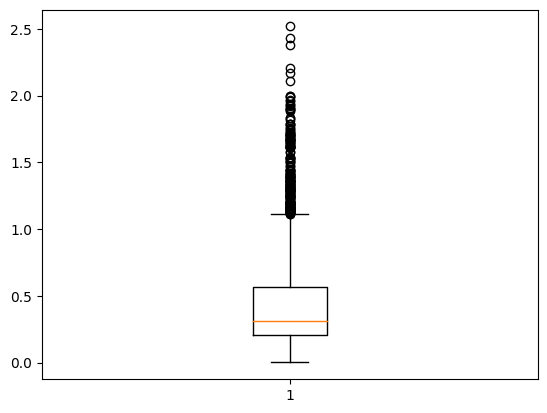

In [310]:
# kgsf_redial_uiop
kgsf_redial_uiop = list(data['UIOP'])
print(np.average(kgsf_redial_uiop))
plt.boxplot(kgsf_redial_uiop)

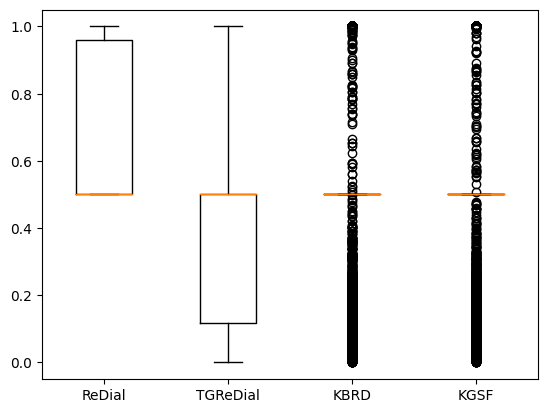

In [311]:
%matplotlib inline
plt.boxplot([redial_redial_cep, tgredial_redial_cep, kbrd_redial_cep, kgsf_redial_cep], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF'])
plt.savefig('cep_bias_only.pdf')

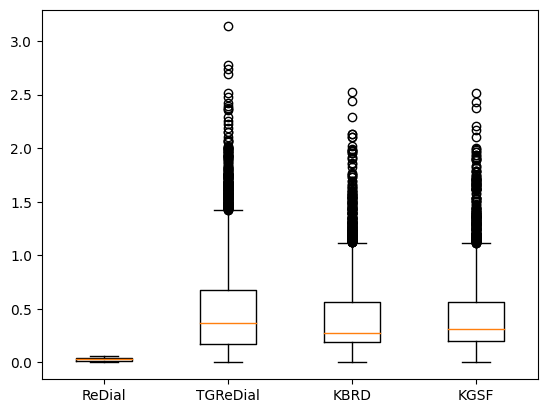

In [312]:
%matplotlib inline
plt.boxplot([redial_redial_uiop, tgredial_redial_uiop, kbrd_redial_uiop, kgsf_redial_uiop], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF'])
plt.savefig('uiop_bias_only.pdf')

### Cross Turn Repetition (CTR) Bias

In [113]:
# Calculate the ctr bias score
import rbo
ctr_scores = []
new_conv = True
for idx, row in data.iterrows():
    if new_conv:
        new_conv = False
    else:
        if idx+1 < len(data) and row['conv_id'] != data.at[idx+1, 'conv_id']:
            new_conv=True
            continue
        ctr_score = rbo.RankingSimilarity(row['Prediction_items'], data.at[idx-1, 'Prediction_items']).rbo(p=0.1)
        ctr_scores.append(ctr_score)

0.9999998548752659


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff3875249d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff387524f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff387524730>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff387525450>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff3875256f0>],
 'means': []}

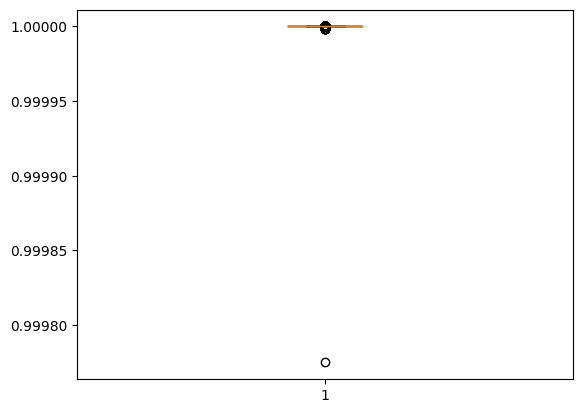

In [99]:
# redial_ctr
import matplotlib.pyplot as plt
redial_ctr_score = ctr_scores
print(np.average(redial_ctr_score))
plt.boxplot(redial_ctr_score)

0.4348471158092639


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff3875aad10>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff3875ab250>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff3875aaa70>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff3875ab7c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff3875aba60>],
 'means': []}

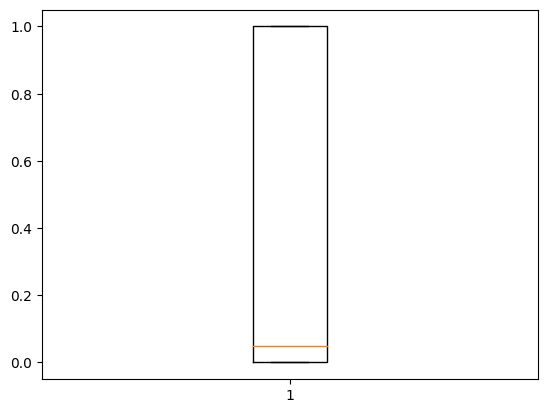

In [104]:
import matplotlib.pyplot as plt
tgredial_ctr_score = ctr_scores
print(np.average(tgredial_ctr_score))
plt.boxplot(tgredial_ctr_score)

0.5719209493651491


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff389afc250>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff389afc790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff389aebf70>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff389afccd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff389afcf70>],
 'means': []}

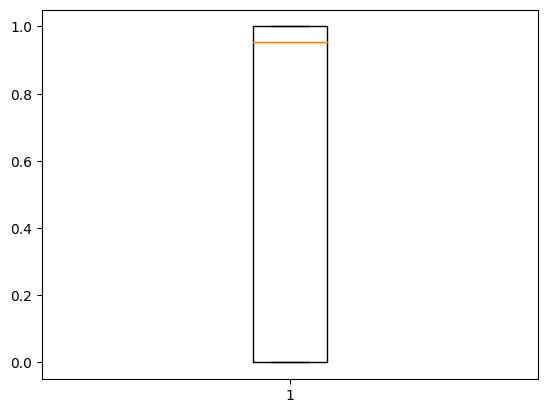

In [114]:
import matplotlib.pyplot as plt
kgsf_ctr_score = ctr_scores
print(np.average(kgsf_ctr_score))
plt.boxplot(kgsf_ctr_score)

0.5501647257584997


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff387559900>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff387559e40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff387559660>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff38755a380>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff38755a620>],
 'means': []}

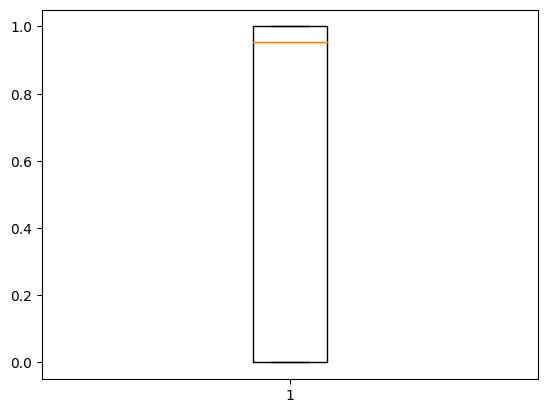

In [109]:
import matplotlib.pyplot as plt
kbrd_ctr_score = ctr_scores
print(np.average(kbrd_ctr_score))
plt.boxplot(kbrd_ctr_score)

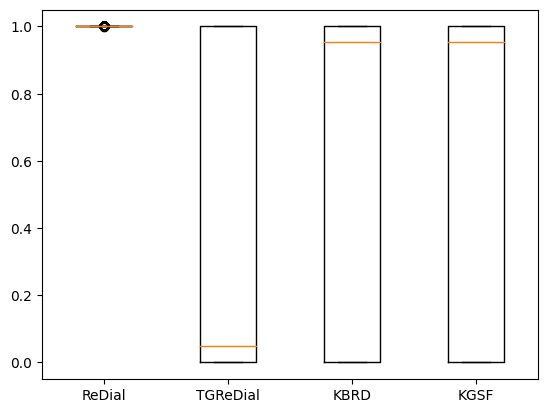

In [115]:
%matplotlib inline
plt.boxplot([redial_ctr_score, tgredial_ctr_score, kbrd_ctr_score, kgsf_ctr_score], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF'])
plt.savefig('ctr_bias_redial.pdf')

In [92]:
# Calculate the IRA bias score
import rbo
ira_scores = []
new_conv = True
initial_idx = 0
for idx, row in data.iterrows():
    if new_conv:
        new_conv = False
    else:
        if idx+1 < len(data) and row['conv_id'] != data.at[idx+1, 'conv_id']:
            new_conv=True
            initial_idx = idx+1
        ira_score = rbo.RankingSimilarity(row['Prediction_items'], data.at[initial_idx, 'Prediction_items']).rbo(p=0.1)
    ira_scores.append(ira_score)

0.9997547246166543


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff389ba5ab0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff389ba5ff0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff389ba5810>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff389ba6530>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff389ba67d0>],
 'means': []}

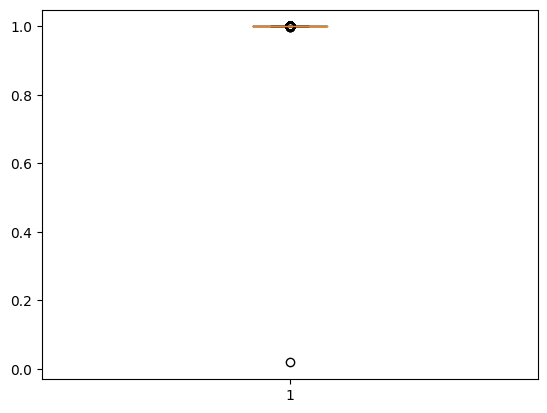

In [78]:
# redial_ira
import matplotlib.pyplot as plt
redial_ira_score = ira_scores
print(np.average(redial_ira_score))
plt.boxplot(redial_ira_score)

0.12573495359721787


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff382cb8580>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff382cb8ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff382cb82e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff382cb9000>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff382cb92a0>],
 'means': []}

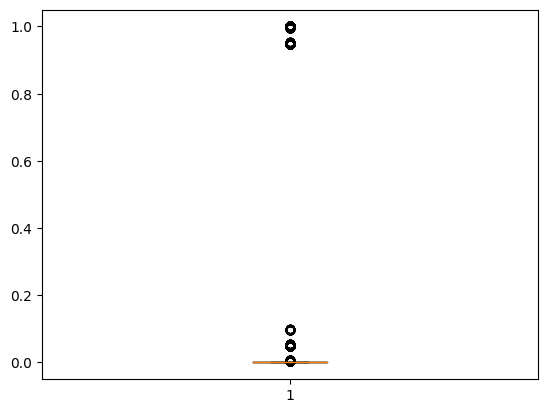

In [83]:
# tgredial_ira
import matplotlib.pyplot as plt
tgredial_ira_score = ira_scores
print(np.average(tgredial_ira_score))
plt.boxplot(tgredial_ira_score)

0.15743476270939472


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff38ba3f040>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff38ba3f580>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff38ba3eda0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff38ba3fac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff38ba3fd60>],
 'means': []}

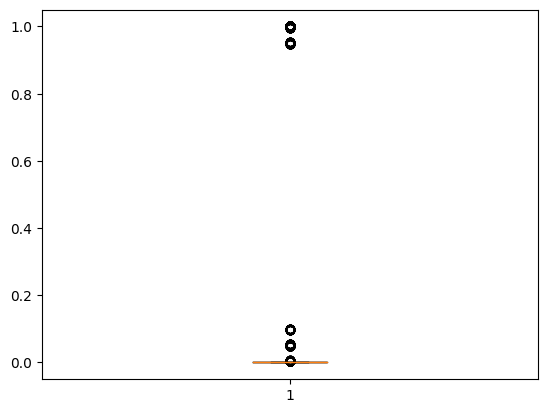

In [88]:
# kbrd_ira
import matplotlib.pyplot as plt
kbrd_ira_score = ira_scores
print(np.average(kbrd_ira_score))
plt.boxplot(kbrd_ira_score)

0.17702558558135228


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff38b8f5c90>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff38b8f61d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff38b8f59f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff38b8f6710>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff38b8f69b0>],
 'means': []}

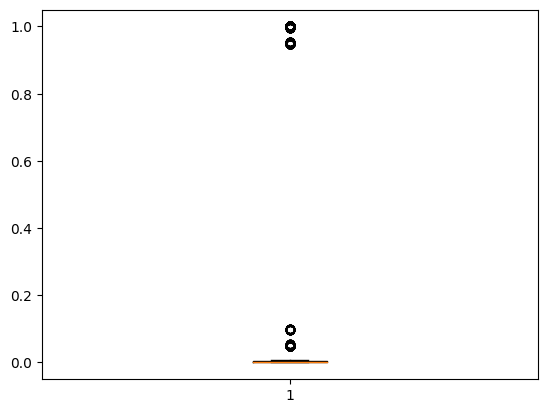

In [93]:
# kgsf_ira
import matplotlib.pyplot as plt
kgsf_ira_score = ira_scores
print(np.average(kgsf_ira_score))
plt.boxplot(kgsf_ira_score)

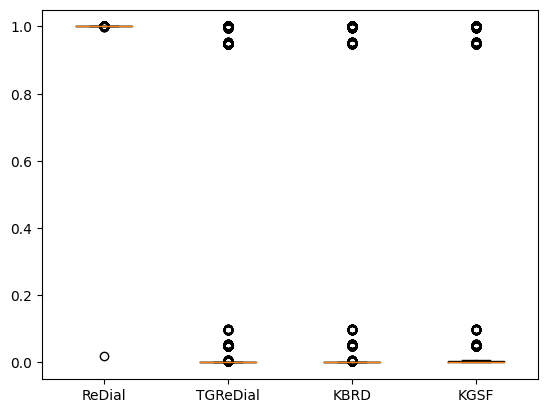

In [94]:
%matplotlib inline
plt.boxplot([redial_ira_score, tgredial_ira_score, kbrd_ira_score, kgsf_ira_score], labels=['ReDial', 'TGReDial', 'KBRD', 'KGSF'])
plt.savefig('ira_bias_redial.pdf')